In [1]:
import tensorflow.keras as kr

In [2]:
import button_pos_script as btp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import transform_data as trans

In [3]:
raw_data = btp.pd_events_to_np(pd.read_csv('test3.csv.csv'))
raw_data2 = btp.pd_events_to_np(pd.read_csv('test4.csv'))
raw_data3 = btp.pd_events_to_np(pd.read_csv('test5.csv'))
raw_data = btp.ev_stack(raw_data, raw_data2, raw_data3)
raw_data.shape

(796, 200, 2)

In [4]:
# Data Normalization
shuffle = np.arange(len(raw_data))
np.random.shuffle(shuffle)
data = raw_data[shuffle]

# data = np.copy(data / [1280, 720])

# resize the dataset (current size - 400 in sample size)

In [4]:
def get_last(event):
    return event[event > 0].reshape(-1, 2)[-1]

def replace_with_last(event):
    return np.where(event == 0, get_last(event), event)

In [5]:
# Data Normalization

# data = np.copy(raw_data / [1280, 720])

def max_sample(event):
    as_pd = pd.DataFrame(event)
    uniques = as_pd.drop_duplicates()
    
    return np.array(uniques).shape[0]

def max_size(events):
    return np.max(np.array([max_sample(i) for i in events]))

data = raw_data[:, 0:max_size(raw_data), :]

datax = np.array([replace_with_last(i) for i in data])
# Transforms the data, duplicating the last position to the rest of the array

In [ ]:
datax.shape

(796, 146, 2)
(796, 144, 2) (796, 144, 2)


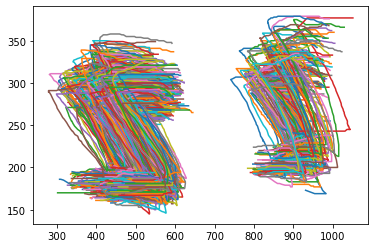

In [6]:
# flatten to m * 2 dimensional array
# dataxx = datax.reshape(-1, 2)
print(datax.shape)

def sequence(m, n):
    li = []
    for i in range(len(m)-n+1):
        li.append(m[i:i+n])
    return np.array(li)

vectors = np.array([trans.ev_tovec(data, True, False)[1] for data in datax])

# [-1, -1] : 0
# [-1, 0] : 1
# [-1, 1] : 2
# [0, -1] : 3
# [0, 0] : 4
# [0, 1] : 5
# [1, -1] : 6
# [1, 0] : 7
# [1, 1] : 8
vectors = np.true_divide((vectors + [180, 0]), [360, 160])
train_xx = vectors[:, 0:144, :]
train_yy = vectors[:, 1:, :]

vectors = vectors.reshape(-1, 2)

print(train_xx.shape, train_yy.shape)

In [ ]:
# train_y = trans.compute_conversion(vectors)
print(train_xx.shape)

In [7]:
print(train_xx[0][0:2])
train_xx = np.array([sequence(event, 6) for event in train_xx])
train_yy = np.array([sequence(event, 6) for event in train_yy])
train_yy = train_yy[:, :, -1, :]
print(train_xx.shape, train_yy.shape)

train_xx = train_xx.reshape(-1, 6, 2)
train_yy = train_yy.reshape(-1, 2)
# train_xx = sequence(train_xx, 1)
# train_yy = sequence(train_yy, 1)
# train_yy = vectors[1:]
# train_xx = train_x[0:-1]

print(train_xx.shape, train_yy.shape)

[[0.47259498 0.14590772]
 [0.5        0.01875   ]]
(796, 139, 6, 2) (796, 139, 2)
(110644, 6, 2) (110644, 2)


In [10]:
print(train_xx[2], train_yy[2])

[[0.5     0.0125 ]
 [0.5     0.01875]
 [0.5     0.00625]
 [0.5     0.01875]
 [0.5     0.00625]
 [0.5     0.0125 ]] [0.5   0.025]


In [160]:
# Model creation and training

model2 = kr.models.Sequential()

# model2.add(kr.layers.Input(shape=(1, 2)))

model2.add(kr.layers.LSTM(40, batch_input_shape=((1, 6, 2)), stateful=True))

model2.add(kr.layers.Dense(30))

model2.add(kr.layers.Dense(2, activation='sigmoid'))

In [161]:
opt = kr.optimizers.Adam(lr=1e-3, decay=1e-5)
model2.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
print(train_xx[1][-1], train_yy[1], train_xx[2][-1])
model2.summary()

[0.5     0.00625] [0.5    0.0125] [0.5    0.0125]
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (1, 40)                   6880      
_________________________________________________________________
dense_14 (Dense)             (1, 30)                   1230      
_________________________________________________________________
dense_15 (Dense)             (1, 2)                    62        
Total params: 8,172
Trainable params: 8,172
Non-trainable params: 0
_________________________________________________________________


In [168]:
# train_xx = np.expand_dims(train_xx, axis=1)
e_len = 460 # 796
st_len = 139

history = []
# model2.train_on_batch(np.expand_dims(train_xx[0], axis=0), np.expand_dims(train_yy[0], axis=0))
for e in range(e_len):
    print('epoch: ', e + 1, '/', e_len)
    for s in range(st_len):
        history = model2.train_on_batch(np.expand_dims(train_xx[s+139*e], axis=0), np.expand_dims(train_yy[s+139*e], axis=0), reset_metrics=False)
    print(history)
    model2.reset_states()
# history = model2.fit(train_xx, train_yy, epochs=10, batch_size=32)

epoch:  1 / 460
[3.6169702e-06, 0.9999601]
epoch:  2 / 460
[6.615243e-07, 0.99996024]
epoch:  3 / 460
[6.2427915e-08, 0.99996036]
epoch:  4 / 460
[4.2708558e-07, 0.9999605]
epoch:  5 / 460
[4.216563e-07, 0.9999606]
epoch:  6 / 460
[1.1208982e-07, 0.99996066]
epoch:  7 / 460
[2.0158342e-07, 0.9999608]
epoch:  8 / 460
[1.8831415e-08, 0.9999609]
epoch:  9 / 460
[1.4126927e-07, 0.999961]
epoch:  10 / 460
[6.206971e-08, 0.99996114]
epoch:  11 / 460
[6.131482e-08, 0.9999612]
epoch:  12 / 460
[2.8136587e-06, 0.9999613]
epoch:  13 / 460
[2.4728138e-06, 0.99996144]
epoch:  14 / 460
[9.177854e-08, 0.99996156]
epoch:  15 / 460
[3.091244e-07, 0.9999616]
epoch:  16 / 460
[1.4125061e-08, 0.99996173]
epoch:  17 / 460
[3.0042648e-07, 0.99996185]
epoch:  18 / 460
[4.9395385e-07, 0.9999619]
epoch:  19 / 460
[2.1732024e-08, 0.99996203]
epoch:  20 / 460
[3.5789296e-06, 0.99996215]
epoch:  21 / 460
[2.2200892e-07, 0.9999622]
epoch:  22 / 460
[7.175758e-08, 0.99996233]
epoch:  23 / 460
[3.106672e-07, 0.9999

In [58]:
model2.fit(train_xx[0:500], train_yy[0:500], epochs=25, shuffle=False)

Train on 500 samples
Epoch 1/25
500/500 [==============================] - 4s 8ms/sample - loss: 0.0161 - accuracy: 1.0000
Epoch 2/25
500/500 [==============================] - 2s 4ms/sample - loss: 0.0153 - accuracy: 1.0000
Epoch 3/25
500/500 [==============================] - 2s 3ms/sample - loss: 0.0138 - accuracy: 1.0000
Epoch 4/25
500/500 [==============================] - 2s 4ms/sample - loss: 0.0118 - accuracy: 1.0000
Epoch 5/25
500/500 [==============================] - 2s 3ms/sample - loss: 0.0091 - accuracy: 1.0000
Epoch 6/25
500/500 [==============================] - 2s 4ms/sample - loss: 0.0061 - accuracy: 1.0000
Epoch 7/25
500/500 [==============================] - 2s 4ms/sample - loss: 0.0039 - accuracy: 1.0000
Epoch 8/25
500/500 [==============================] - 2s 3ms/sample - loss: 0.0028 - accuracy: 1.0000
Epoch 9/25
500/500 [==============================] - 2s 3ms/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 10/25
500/500 [==============================] - 2s 3ms

tf.Tensor([[0.50085324 0.02336871]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.50623596 0.01793502]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.50349545 0.01383544]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.4994521  0.01454406]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.5041262  0.01181383]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.5058801  0.01048407]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.50653106 0.00921494]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.5046313  0.00859305]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.50160086 0.00889926]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.50175047 0.00844409]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.50185025 0.00846503]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.8327728  0.01011227]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.8945572  0.02181196]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.90581936 0.02715957]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.8907264  0.03088423]], shape=(1, 2), dtype=float32)
[[0.501750

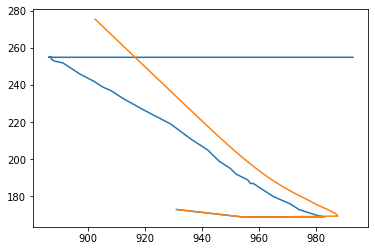

In [206]:
def get_nextpos(coord, direct):
        next_pos = coord + [0, np.sin(direct[0] * np.pi / 180) * direct[1]]
        next_pos = next_pos + [np.cos(direct[0] * np.pi / 180) * direct[1], 0]
        return next_pos

def trayectory(directions, initial_point):
    denormalized = directions * [360, 160] - [180, 0]
    # print(denormalized)
    li = []
    # print(denormalized[0])
    nexti = initial_point
    li.append(nexti)
    for i in range(len(denormalized)):
        nexti = get_nextpos(nexti, denormalized[i])
        # print(nexti)
        li.append(nexti.tolist())
    
    return np.array(li)

event = 0
context = 15
current = train_xx
li = train_xx[0]
current_d = datax[event][0:6]

for i in range(context):
    predict = model2.predict_on_batch(np.expand_dims(current[i], axis=0))
    print(predict)
    li = np.concatenate((li, np.expand_dims(predict[0], axis=0)))

# for i in range(context):
#     predict = model2.predict_on_batch(np.expand_dims(train_xx[i], axis=0))
#     print(predict)
#     li = np.concatenate((li, np.expand_dims(predict[0], axis=0)))

current = li[-6:]
print(current)
trans.plot_events(datax[event])
for i in range(20):
    # print(i, current)
    predict = model2.predict_on_batch(np.expand_dims(current, axis=0))
    current = np.concatenate((current[1:], predict))

    # print(i, current[-5:]) if i > 0 else None
    li = np.concatenate((li, np.expand_dims(predict[0], axis=0)))

result = trayectory(li, datax[event][0])
trans.plot_events(result)

model2.reset_states()

In [ ]:
test = 0

li = []
current = 
for i in range(2):
    prediction = model2.predict(np.array([train_xx[test]]))
    print(train_xx[0], prediction)
    trans.plot_events(datax[test])
    # trayect = trayectory(prediction, datax[test][5])
    trans.plot_events(trayect)
    model2.reset_states()